In [1]:
import numpy as np
import sklearn
from sklearn import model_selection
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from time import sleep
import matplotlib.gridspec as gridspec


def load_data(data_name):
    with np.load(data_name) as fh:
        data_x = fh['data_x']
        data_y = fh['data_y']
    return data_x, data_y



## Model definition
## Encoder


class Encoder(torch.nn.Module):
    """Documentation for Encoder

    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.e1 = torch.nn.Linear(input_dim, hidden_dim)
        self.e2 = torch.nn.Linear(hidden_dim, 2*hidden_dim)
        self.e3 = torch.nn.Linear(2*hidden_dim, latent_dim)
        self.e4 = torch.nn.Linear(2*hidden_dim, latent_dim)

    def forward(self, x):
        x = F.leaky_relu(self.e1(x))
        x = F.leaky_relu(self.e2(x))
        mean = self.e3(x)
        log_variance = self.e4(x)
        return mean, log_variance


## Decoder


class Decoder(torch.nn.Module):
    """Documentation for Decoder

    """
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.d1 = torch.nn.Linear(latent_dim, 2*hidden_dim)
        self.d2 = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.d3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.d1(x))
        x = F.leaky_relu(self.d2(x))
        # output = F.softmax(self.d3(x))
        output = torch.sigmoid(self.d3(x))        
        return output


## VAE


class VAE(torch.nn.Module):
    """Documentation for VAE

    """
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, log_variance):
        variance = torch.exp(.5 * log_variance)
        epsilon = torch.randn_like(variance).to(DEVICE)
        z = mean + variance * epsilon
        return z

    def forward(self, x):
        mean, log_variance = self.Encoder(x)
        z = self.reparameterization(mean, log_variance)
        output = self.Decoder(z)
        return output, mean, log_variance


## Loss function

def loss_func(output, x, mean, log_variance):
    loss_reproduction = F.binary_cross_entropy(output, x, reduction='sum')
    kld = -.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
    return loss_reproduction + kld


In [2]:
data_name = 'vae-cvae-challenge.npz'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_dim = 784
batch_size = 1024
hidden_dim = 256
latent_dim = 2
epochs = 30
lr = .001
# load the data
data_x, data_y = load_data(data_name)
print(data_x.shape, data_y.shape)

(20000, 784) (20000,)


In [3]:
data_train = torch.from_numpy(data_x)
label_train = torch.from_numpy(data_y)
dataset_train = TensorDataset(data_train, label_train)   
dl_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [4]:
encoder = Encoder(x_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, x_dim)
vae = VAE(encoder, decoder)
optimizer = Adam(vae.parameters(), lr=lr)
#mse = torch.nn.MSELoss()

In [5]:
loss_list = []
for epoch in tqdm(range(epochs)):
    losses = 0
    # unsupervised.
    for idx, (x, _) in enumerate(dl_train):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        output, mean, log_variance = vae(x)
        loss = loss_func(output, x, mean, log_variance)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        loss_list += [loss.item() / batch_size]
    #sleep(.01)
    print(f' training loss -- {losses / (idx * batch_size)}') 

  3%|▎         | 1/30 [00:00<00:28,  1.02it/s]

 training loss -- 346.35197529039885


  7%|▋         | 2/30 [00:01<00:23,  1.19it/s]

 training loss -- 217.25616936934622


 10%|█         | 3/30 [00:02<00:22,  1.21it/s]

 training loss -- 206.74791757684005


 13%|█▎        | 4/30 [00:03<00:21,  1.22it/s]

 training loss -- 200.38618348774156


 17%|█▋        | 5/30 [00:04<00:22,  1.09it/s]

 training loss -- 195.72108138234992


 20%|██        | 6/30 [00:05<00:21,  1.11it/s]

 training loss -- 189.9463842291581


 23%|██▎       | 7/30 [00:06<00:20,  1.15it/s]

 training loss -- 185.67358077199836


 27%|██▋       | 8/30 [00:06<00:18,  1.19it/s]

 training loss -- 182.30649687114516


 30%|███       | 9/30 [00:07<00:17,  1.22it/s]

 training loss -- 179.37988843415914


 33%|███▎      | 10/30 [00:08<00:16,  1.25it/s]

 training loss -- 177.00505507619758


 37%|███▋      | 11/30 [00:09<00:15,  1.22it/s]

 training loss -- 175.1505255448191


 40%|████      | 12/30 [00:10<00:14,  1.25it/s]

 training loss -- 173.40386762117086


 43%|████▎     | 13/30 [00:10<00:13,  1.24it/s]

 training loss -- 171.99660251015112


 47%|████▋     | 14/30 [00:11<00:12,  1.25it/s]

 training loss -- 170.62449043675474


 50%|█████     | 15/30 [00:12<00:12,  1.21it/s]

 training loss -- 169.17168225740133


 53%|█████▎    | 16/30 [00:13<00:11,  1.23it/s]

 training loss -- 167.99088126734682


 57%|█████▋    | 17/30 [00:14<00:10,  1.20it/s]

 training loss -- 167.10857953523336


 60%|██████    | 18/30 [00:15<00:10,  1.11it/s]

 training loss -- 166.09062636526008


 63%|██████▎   | 19/30 [00:16<00:09,  1.12it/s]

 training loss -- 165.19150221975227


 67%|██████▋   | 20/30 [00:16<00:08,  1.17it/s]

 training loss -- 164.36709032560648


 70%|███████   | 21/30 [00:17<00:07,  1.16it/s]

 training loss -- 163.56979089034232


 73%|███████▎  | 22/30 [00:18<00:06,  1.18it/s]

 training loss -- 162.8904117785002


 77%|███████▋  | 23/30 [00:19<00:05,  1.20it/s]

 training loss -- 162.24463814183287


 80%|████████  | 24/30 [00:20<00:04,  1.24it/s]

 training loss -- 161.6871129086143


 83%|████████▎ | 25/30 [00:20<00:04,  1.24it/s]

 training loss -- 161.00778599789268


 87%|████████▋ | 26/30 [00:21<00:03,  1.20it/s]

 training loss -- 160.58097678736635


 90%|█████████ | 27/30 [00:22<00:02,  1.19it/s]

 training loss -- 160.20224922581724


 93%|█████████▎| 28/30 [00:23<00:01,  1.20it/s]

 training loss -- 159.4859783774928


 97%|█████████▋| 29/30 [00:24<00:00,  1.20it/s]

 training loss -- 159.08206096448396


100%|██████████| 30/30 [00:25<00:00,  1.19it/s]

 training loss -- 158.68418402420846


## Save model

In [6]:
torch.save(vae.state_dict(), "vae_model")

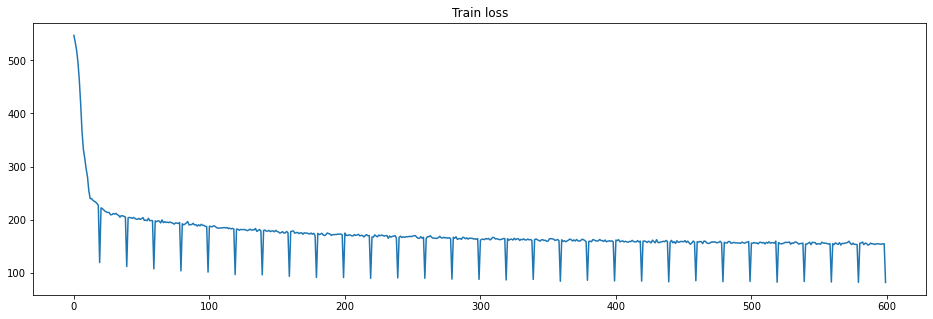

In [7]:
import matplotlib.pyplot as plt
# visualize losses
f, ax = plt.subplots(figsize=(16, 5))
ax.plot(loss_list)
ax.title.set_text("Train loss")

## Load model

In [8]:
vae = VAE(Encoder(x_dim, hidden_dim, latent_dim),Decoder(latent_dim, hidden_dim, x_dim))
vae.load_state_dict(torch.load("vae_model"))

<All keys matched successfully>

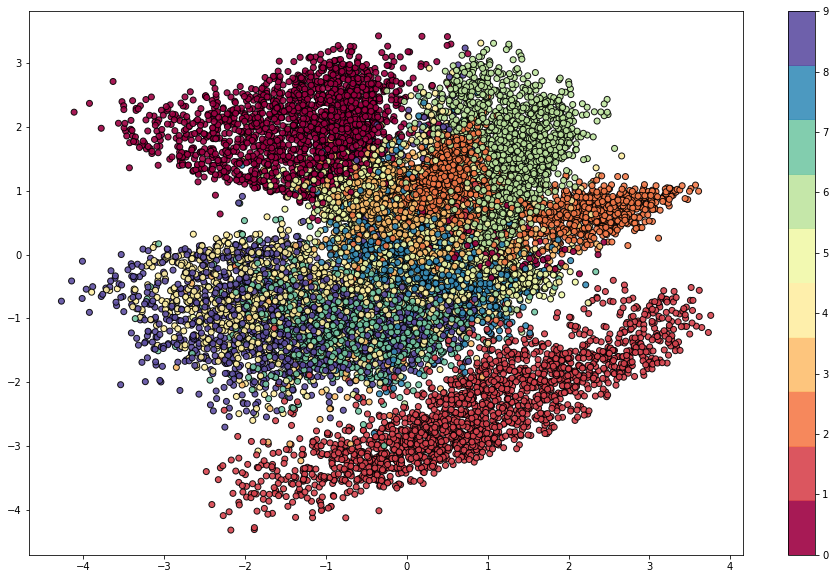

In [11]:
#plt.cla()
fig, axe = plt.subplots(figsize=(16, 10))
train_data_sec = data_train[:]
label_data_sec = label_train[:]
mu, log_variance = vae.Encoder(train_data_sec)
mu_x = mu.detach().numpy()[:, 0]
mu_y = mu.detach().numpy()[:, 1]
labels = label_data_sec.detach().numpy()
plt.scatter(mu_x, mu_y, c=labels, cmap=plt.cm.get_cmap('Spectral', 10), alpha=.9, edgecolors='black')
#plt.xlim(np.percentile(mu_x, 0.1), np.percentile(mu_y, 99.9))
#plt.ylim(np.percentile(mu_y, 0.1), np.percentile(mu_y, 99.9))
plt.colorbar()
#plt.show()

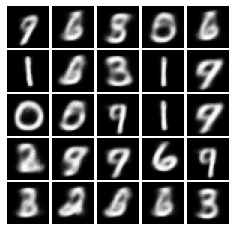

In [13]:
samples, _, _ = vae(train_data_sec)
grid_x = 5
sample_size = grid_x**2
ids = np.random.randint(0, samples.shape[0], sample_size)
samples = samples[ids].detach().numpy()
fig_dec = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(grid_x, grid_x)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')